In [89]:
conda install shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression

from sklearn import datasets, linear_model
from scipy import linalg
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy import stats as st
# –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–æ–≥–æ API
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

### 1. –ò—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö

In [3]:
df = pd.read_csv('./datasets/automobile.csv')
df.head()

Price          Make    Location  Age  Odometer FuelType Transmission  \
0   1.75  marutiwagonr      Mumbai   10     72000      CNG       Manual   
1  12.50  hyundaicreta        Pune    5     41000   Diesel       Manual   
2   4.50     hondajazz     Chennai    9     46000   Petrol       Manual   
3   6.00  marutiertiga     Chennai    8     87000   Diesel       Manual   
4  17.74        audia4  Coimbatore    7     40670   Diesel    Automatic   

  OwnerType Mileage EngineCC PowerBhp  
0     First    26.6      998    58.16  
1     First   19.67     1582    126.2  
2     First    18.2     1199     88.7  
3     First   20.77     1248    88.76  
4    Second    15.2     1968    140.8

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         6019 non-null   float64
 1   Make          6019 non-null   object 
 2   Location      6019 non-null   object 
 3   Age           6019 non-null   int64  
 4   Odometer      6019 non-null   int64  
 5   FuelType      6019 non-null   object 
 6   Transmission  6019 non-null   object 
 7   OwnerType     6019 non-null   object 
 8   Mileage       6019 non-null   object 
 9   EngineCC      6019 non-null   object 
 10  PowerBhp      6019 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 517.4+ KB


In [5]:
for col,colNew in zip(['Mileage', 'EngineCC', 'PowerBhp'],['mileage', 'engineCC', 'powerBhp']):
    df[col] = df[col].replace('+AC0-1',None)
    df[colNew] = df[col].astype('float')

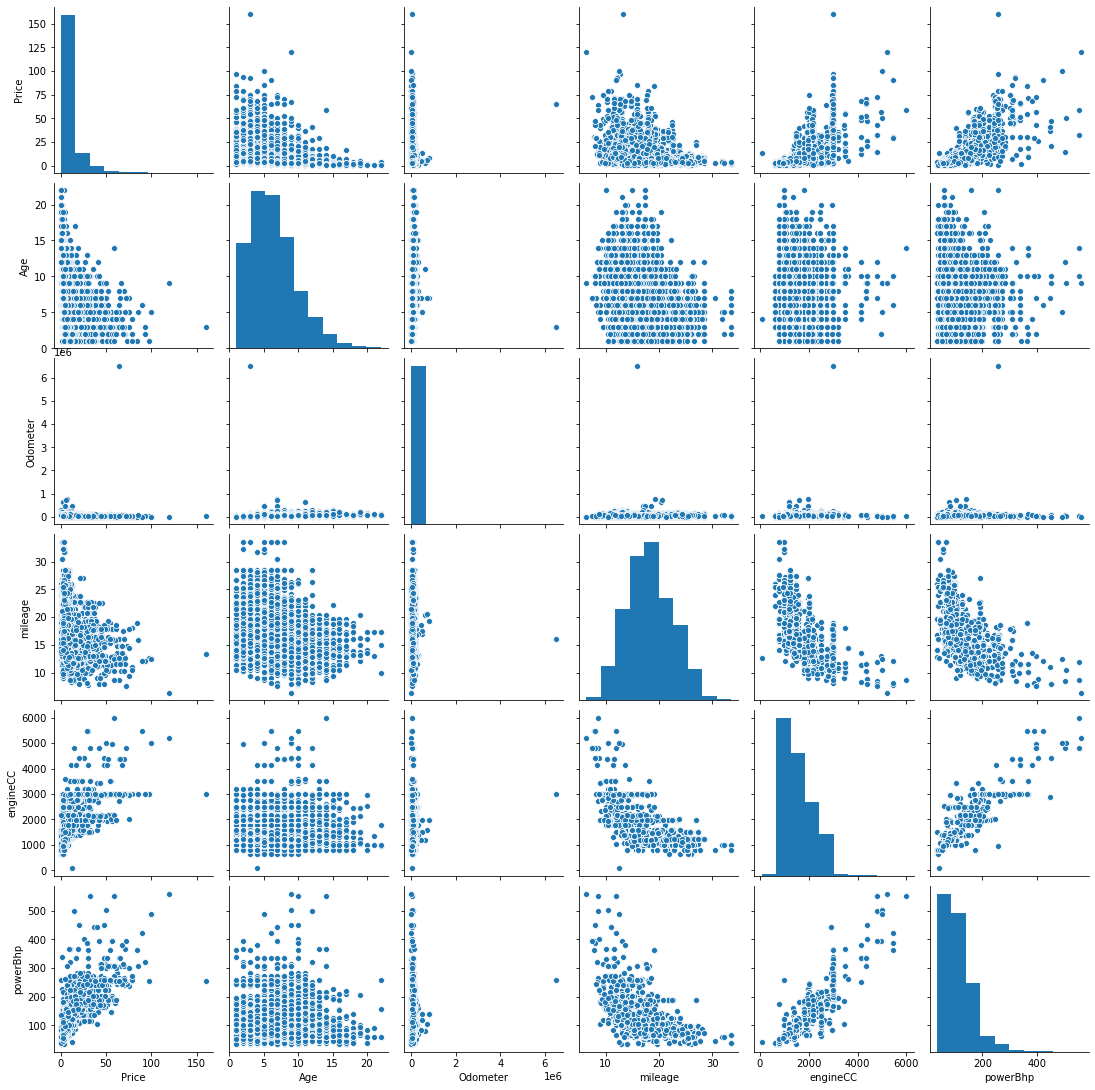

In [6]:
sns.pairplot(df[['Price','Age','Odometer','mileage', 'engineCC', 'powerBhp']])

In [7]:
corrl = (df[['Price','Age','Odometer','mileage','engineCC','powerBhp']]).corr()
corrl.style.background_gradient(cmap='coolwarm')

In [8]:
np.where((df[['Price','Age','Odometer','mileage','engineCC','powerBhp']]).
corr()>0.6,'Yes','No')

array([['Yes', 'No', 'No', 'No', 'Yes', 'Yes'],
       ['No', 'Yes', 'No', 'No', 'No', 'No'],
       ['No', 'No', 'Yes', 'No', 'No', 'No'],
       ['No', 'No', 'No', 'Yes', 'No', 'No'],
       ['Yes', 'No', 'No', 'No', 'Yes', 'Yes'],
       ['Yes', 'No', 'No', 'No', 'Yes', 'Yes']], dtype='<U3')

Power BHP is highly positively correlated with the Price\
EngineCC is also highly correlated with the Price\
Power BHP is also highly correlated with the EngineCC

In [9]:
#create dummy vars
Location_dummy = pd.get_dummies(df.Location,prefix='Location',drop_first=True)
FuelType_dummy = pd.get_dummies(df.FuelType,prefix='FuelType',drop_first=True)
Transmission_dummy = pd.get_dummies(df.Transmission,prefix='Transmission',drop_first=True)
OwnerType_dummy = pd.get_dummies(df.OwnerType,prefix='OwnerType',drop_first=True)
combine_all_dummy = pd.concat([df,Location_dummy,FuelType_dummy,Transmission_dummy, OwnerType_dummy],axis=1)
print(combine_all_dummy.columns)
combine_all_dummy.head()

Index(['Price', 'Make', 'Location', 'Age', 'Odometer', 'FuelType',
       'Transmission', 'OwnerType', 'Mileage', 'EngineCC', 'PowerBhp',
       'mileage', 'engineCC', 'powerBhp', 'Location_Bangalore',
       'Location_Chennai', 'Location_Coimbatore', 'Location_Delhi',
       'Location_Hyderabad', 'Location_Jaipur', 'Location_Kochi',
       'Location_Kolkata', 'Location_Mumbai', 'Location_Pune',
       'FuelType_Diesel', 'FuelType_Electric', 'FuelType_LPG',
       'FuelType_Petrol', 'Transmission_Manual',
       'OwnerType_Fourth +ACY- Above', 'OwnerType_Second', 'OwnerType_Third'],
      dtype='object')


Price          Make    Location  Age  Odometer FuelType Transmission  \
0   1.75  marutiwagonr      Mumbai   10     72000      CNG       Manual   
1  12.50  hyundaicreta        Pune    5     41000   Diesel       Manual   
2   4.50     hondajazz     Chennai    9     46000   Petrol       Manual   
3   6.00  marutiertiga     Chennai    8     87000   Diesel       Manual   
4  17.74        audia4  Coimbatore    7     40670   Diesel    Automatic   

  OwnerType Mileage EngineCC  ... Location_Mumbai  Location_Pune  \
0     First    26.6      998  ...               1              0   
1     First   19.67     1582  ...               0              1   
2     First    18.2     1199  ...               0              0   
3     First   20.77     1248  ...               0              0   
4    Second    15.2     1968  ...               0              0   

   FuelType_Diesel  FuelType_Electric  FuelType_LPG  FuelType_Petrol  \
0                0                  0             0                0   
1                1                  0             0                0   
2                0                  0             0                1   
3                1                  0             0                0   
4                1                  0             0                0   

   Transmission_Manual  OwnerType_Fourth +ACY- Above  OwnerType_Second  \
0                    1                             0                 0   
1                    1                             0                 0   
2                    1                             0                 0   
3                    1                             0                 0   
4                    0                             0                 1   

   OwnerType_Third  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 32 columns]

In [10]:
#clean usefull cols
clean_df = combine_all_dummy.drop(columns=['Make','Location','FuelType','Transmission','OwnerType', 'Mileage', 'EngineCC','PowerBhp'])

In [11]:
clean_df.columns

Index(['Price', 'Age', 'Odometer', 'mileage', 'engineCC', 'powerBhp',
       'Location_Bangalore', 'Location_Chennai', 'Location_Coimbatore',
       'Location_Delhi', 'Location_Hyderabad', 'Location_Jaipur',
       'Location_Kochi', 'Location_Kolkata', 'Location_Mumbai',
       'Location_Pune', 'FuelType_Diesel', 'FuelType_Electric', 'FuelType_LPG',
       'FuelType_Petrol', 'Transmission_Manual',
       'OwnerType_Fourth +ACY- Above', 'OwnerType_Second', 'OwnerType_Third'],
      dtype='object')

Before proceeding to creating a Linear Regression Model, we need to verify the assumptions of LR\
–∏—Å—Å–ª–æ–¥–æ–≤–∞—Ç—å a linear relationship\
All variables follow a normal distribution\
There is very little or no multicollinearity\
There is little or no autocorrelation\
Data is homoscedastic

–ü—Ä–µ–∂–¥–µ —á–µ–º –ø—Ä–∏—Å—Ç—É–ø–∏—Ç—å –∫ —Å–æ–∑–¥–∞–Ω–∏—é –º–æ–¥–µ–ª–∏ –ª–∏–Ω–µ–π–Ω–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏, –Ω–∞–º –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –ø—Ä–æ–≤–µ—Ä–∏—Ç—å –ø—Ä–µ–¥–ø–æ–ª–æ–∂–µ–Ω–∏—è LR\
–∏—Å—Å–ª–µ–¥—É–µ—Ç—Å—è –ª–∏–Ω–µ–π–Ω–∞—è –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç—å\
–í—Å–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ –∏–º–µ—é—Ç –Ω–æ—Ä–º–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ\
–ú—É–ª—å—Ç–∏–∫–æ–ª–ª–∏–Ω–µ–∞—Ä–Ω–æ—Å—Ç—å –æ—á–µ–Ω—å –º–∞–ª–∞ –∏–ª–∏ –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç\
–ê–≤—Ç–æ–∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è –Ω–µ–∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–∞ –∏–ª–∏ –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç\
–î–∞–Ω–Ω—ã–µ –≥–æ–º–æ—Å–∫–µ–¥–∞—Å—Ç–∏—á–Ω—ã

investigating a linear relationship\
as seen before from corr matrix  Power BHP is highly correlated with Price and EngineCC is significant correlated

–∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ –ª–∏–Ω–µ–π–Ω–æ–π –≤–∑–∞–∏–º–æ—Å–≤—è–∑–∏\
–∏–∑ –º–∞—Ç—Ä–∏—Ü—ã corr –≤–∏–¥–Ω–æ, Power BHP —Å–∏–ª—å–Ω–æ –∫–æ—Ä—Ä–µ–ª–∏—Ä—É–µ—Ç —Å —Ü–µ–Ω–æ–π, –∞ EngineCC –∏–º–µ–µ—Ç –º –Ω–µ–π –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω—É—é –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—é, –æ–¥–Ω–∞–∫–∫–æ –Ω–µ –≤—ã—à–µ 0.9 –≤ –∞–±—Å–æ–ª—é—Ç–Ω–æ–º –≤—ã—Ä–∞–∂–µ–Ω–∏–∏

—Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ

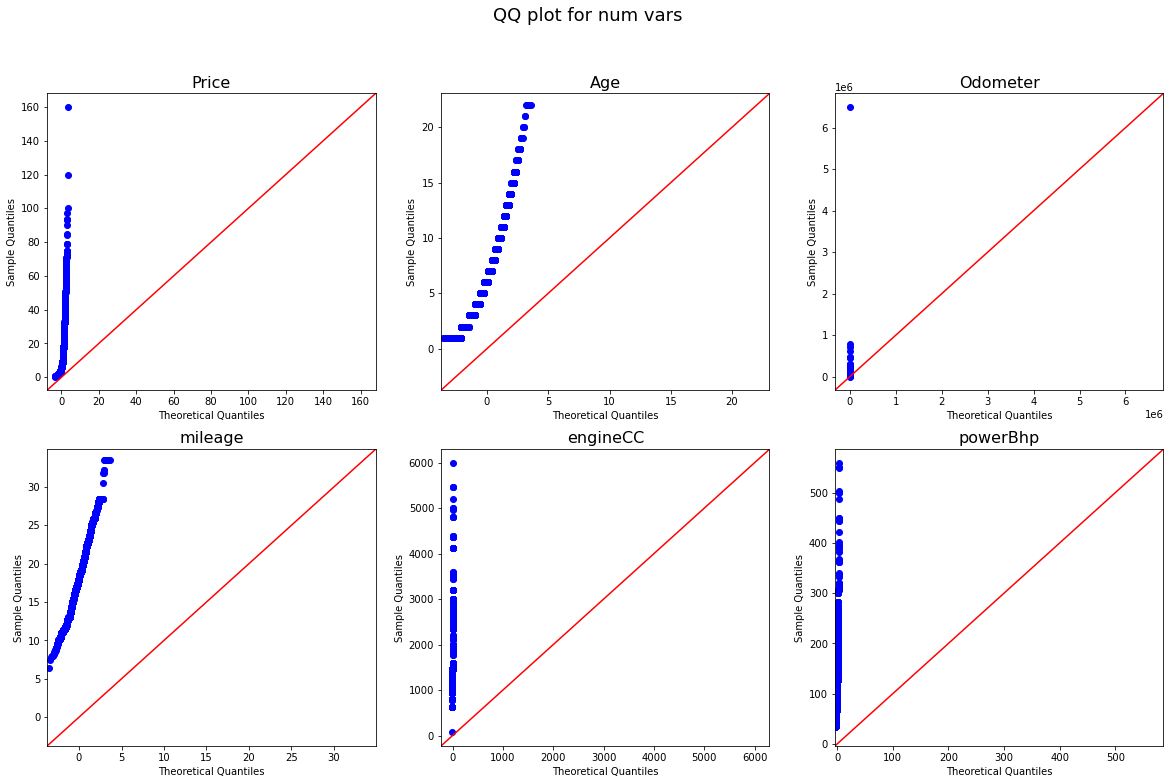

In [12]:
fig, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3,figsize=(20,12))
fig.suptitle('QQ plot for num vars',fontsize=18)

for col,axes  in zip(['Price','Age','Odometer','mileage','engineCC','powerBhp'],[ax1, ax2, ax3,ax4,ax5,ax6]):
    sm.qqplot(clean_df[col], line ='45', ax = axes)
    axes.set_title(col,fontsize=16)
plt.show()

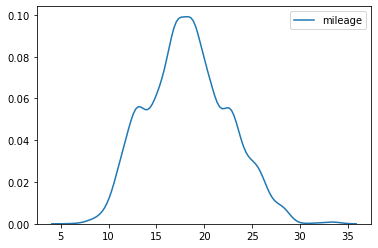

In [91]:
sns.kdeplot(clean_df.mileage)

In [13]:
#–¢–µ—Å—Ç –ö–æ–ª–º–æ–≥–æ—Ä–æ–≤–∞ –°–º–∏—Ä–Ω–æ–≤–∞ –Ω–∞ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç—å
alpha = 0.05
for col  in ['Price','Age','Odometer','mileage','engineCC','powerBhp']:
    D, pval = stats.kstest(clean_df[col],'norm')
    if pval < alpha:
        print(f'{col} is not normal')
    else:
        print(f'{col} is normal')

Price is not normal
Age is not normal
Odometer is not normal
mileage is not normal
engineCC is not normal
powerBhp is not normal


—Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –Ω–µ –±–ª–∏–∑–∫–∏ –∫ –Ω–æ—Ä–º–∞–ª—å–Ω–æ–º—É, millage –≤—ã–≥–ª—è–¥–∏—Ç –ø—Ä–∏–±–ª–∏–∑–∏—Ç–µ–ª—å–Ω–æ –Ω–æ—Ä–º–ª–∞—å–Ω—ã–º

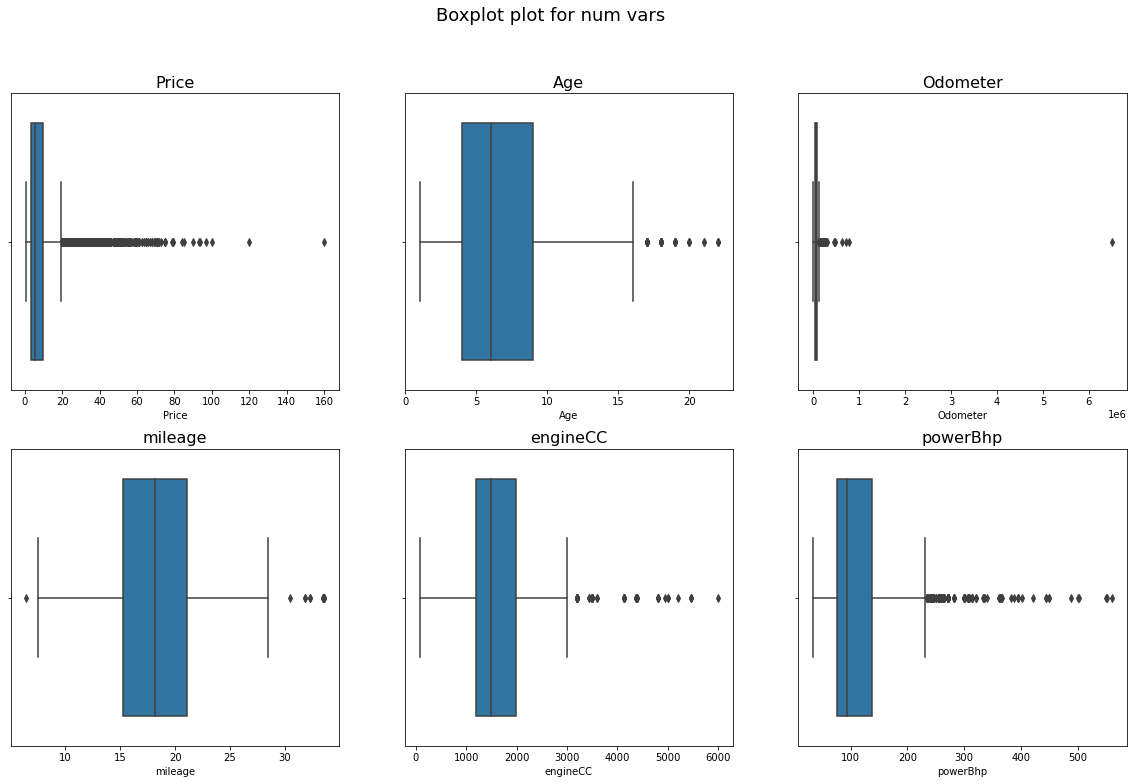

In [14]:
fig, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3,figsize=(20,12))
fig.suptitle('Boxplot plot for num vars',fontsize=18)
for col,axes  in zip(['Price','Age','Odometer','mileage','engineCC','powerBhp'],[ax1, ax2, ax3,ax4,ax5,ax6]):
    sns.boxplot(clean_df[col], ax = axes)
    axes.set_title(col,fontsize=16)
plt.show()

In [15]:
# Q3 + 1.5*IQR
def find_outliers(x):
    IQR = x.describe()[6]-x.describe()[4] #Q3-Q1
    UCL = x.describe()[6] + 1.5*IQR # Q3+1.5*IQR
    LCL = x.describe()[4] - 1.5*IQR #Q1-1.5*IQR
    H_values = x[x > UCL] # outliers on the higher side
    L_values = x[x < LCL] #outliers on the lower side
    return(len(H_values),len(L_values)) #number of outliers

In [16]:
for col  in ['Price','Age','Odometer','mileage','engineCC','powerBhp']:
    ots = find_outliers(clean_df[col])
    print(f'{col} outliers on the higher side: {ots[0]},  outliers on the lower side: {ots[1]}')

Price outliers on the higher side: 718,  outliers on the lower side: 0
Age outliers on the higher side: 50,  outliers on the lower side: 0
Odometer outliers on the higher side: 202,  outliers on the lower side: 0
mileage outliers on the higher side: 14,  outliers on the lower side: 1
engineCC outliers on the higher side: 61,  outliers on the lower side: 0
powerBhp outliers on the higher side: 239,  outliers on the lower side: 0


–í –∑–∞–≤–∏—Å–∏–º—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö –º–Ω–æ–≥–æ –≤—ã–±—Ä–æ—Å–æ–≤, –Ω—É–∂–Ω–æ –æ–±—Ä–∞–±–æ—Ç–∞—Ç—å –∏—Ö.
–µ—Å—Ç—å –Ω–µ—Å–∫–æ–ª—å–∫–æ –≤–∞—Ä–∏–∞–Ω—Ç–æ–≤ –¥–ª—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ –≤—ã–±—Ä–æ—Å–æ–≤:
1. –ó–Ω–∞—Ç—å –æ –≤—ã–±—Ä–æ—Å–∞—Ö, —Å—á–∏—Ç–∞—Ç—å –∏—Ö —Ä–µ–∞–ª—å–Ω–æ—Å—Ç—å—é, –ø—Ä–æ–¥–æ–ª–∂–∞—Ç—å –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏–µ.
2. –£–¥–∞–ª–∏—Ç—å –≤—ã–±—Ä–æ—Å—ã –∏–∑ –Ω–∞–±–æ—Ä–∞ –¥–∞–Ω–Ω—ã—Ö, —ç—Ç–æ –ø–æ—Ç–µ—Ä–µ –¥–∞–Ω–Ω—ã—Ö, –ø–æ—Ç–µ—Ä–µ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏.
3. –£–º–µ–Ω—å—à–∏—Ç–µ –ø–æ—Ä–æ–≥–æ–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –≤—ã–±—Ä–æ—Å–æ–≤, –≤—Å–µ, —á—Ç–æ –±–æ–ª—å—à–µ UCL = Q3, –∏ –º–µ–Ω—å—à–µ LCL = Q1, –º—ã –º–æ–∂–µ–º –ø–æ—Å—Ç—Ä–æ–∏—Ç—å —Ö–æ—Ä–æ—à—É—é –º–æ–¥–µ–ª—å, –Ω–æ –µ–π –±—É–¥–µ—Ç –Ω–µ —Ö–≤–∞—Ç–∞—Ç—å —Ä–µ–∞–ª—å–Ω–æ—Å—Ç–∏.
4. –ó–∞–º–µ–Ω–∞ –≤—ã–±—Ä–æ—Å—ã —Å—Ä–µ–¥–Ω–∏–º, —Å—Ä–µ–¥–Ω–∏–º –∑–Ω–∞—á–µ–Ω–∏–µ–º –∏ —Ç.–¥.


In [17]:
# feats = [col for col in  clean_df.columns if col!='Price']
# data_train, data_test = train_test_split(clean_df,test_size=0.25,random_state=1234)
# XTrain = np.array(data_train[feats])
# YTrain = np.array(data_train['Price'])
# XTest = np.array(data_test[feats])
# YTest = np.array(data_test['Price'])
# XTrain.shape, XTest.shape

### 2. –õ–∏–Ω–µ–π–Ω–∞—è —Ä–µ–≥—Ä–µ—Å—Å–∏—è

In [18]:
data_train, data_test = train_test_split(clean_df,test_size=0.25,random_state=1234)
XTrain = np.array(data_train.iloc[:,0:(clean_df.shape[1]-1)])
YTrain = np.array(data_train['Price'])
XTest = np.array(data_test.iloc[:,0:(clean_df.shape[1]-1)])
YTest = np.array(data_test['Price'])
XTrain.shape, XTest.shape

((4514, 23), (1505, 23))

In [19]:
#–º–æ–¥–µ–ª—å –º–Ω–æ–∂–µ—Å—Ç–≤–µ–Ω–Ω–æ–π –ª–∏–Ω–µ–π–Ω–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏
reg = linear_model.LinearRegression()
reg.fit(XTrain,YTrain) #–æ–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
print('Coefficients: \n', np.round(reg.coef_,4))
print('Intercept: \n', np.round(reg.intercept_,0))
reg.score(XTrain,YTrain) # –∑–Ω–∞—á–µ–Ω–∏–µ R-–∫–≤–∞–¥—Ä–∞—Ç –¥–ª—è –æ–±—É—á–µ–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏
reg.score(XTest,YTest) # –∑–Ω–∞—á–µ–Ω–∏–µ R-–∫–≤–∞–¥—Ä–∞—Ç –¥–ª—è —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –Ω–∞–±–æ—Ä–∞

Coefficients: 
 [ 1.  0.  0. -0. -0.  0.  0.  0.  0.  0. -0.  0.  0.  0. -0.  0. -0.  0.
 -0.  0.  0. -0. -0.]
Intercept: 
 0.0


1.0

In [20]:
y = np.array(clean_df['Price'])
xx = np.array(clean_df[['Price', 'Age', 'Odometer', 'mileage', 'engineCC',
'powerBhp',
'Location_Bangalore', 'Location_Chennai', 'Location_Coimbatore',
'Location_Delhi', 'Location_Hyderabad', 'Location_Jaipur',
'Location_Kochi', 'Location_Kolkata', 'Location_Mumbai',
'Location_Pune', 'FuelType_Diesel', 'FuelType_Electric', 'FuelType_LPG',
'FuelType_Petrol', 'Transmission_Manual',
'OwnerType_Fourth +ACY- Above', 'OwnerType_Second', 'OwnerType_Third']])
mod = sm.OLS(y, xx)
results = mod.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.420e+28
Date:                Sun, 19 Mar 2023   Prob (F-statistic):                        0.00
Time:                        17:21:53   Log-Likelihood:                      1.5537e+05
No. Observations:                6019   AIC:                                 -3.107e+05
Df Residuals:                    5995   BIC:                                 -3.105e+05
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [21]:
# –≠—Ç–æ –º–æ–∂–µ—Ç —É–∫–∞–∑—ã–≤–∞—Ç—å –Ω–∞ –Ω–∞–ª–∏—á–∏–µ —Å–∏–ª—å–Ω–æ–π –º—É–ª—å—Ç–∏–∫–æ–ª–ª–∏–Ω–µ–∞—Ä–Ω–æ—Å—Ç–∏
print('Parameters: ', results.params)
print('R2: ', results.rsquared)
print('Standard errors: ', results.bse)
print('Predicted values: ', results.predict())

Parameters:  [ 1.00000000e+00  2.61265619e-16 -1.35474851e-17  1.24566698e-15
 -1.14374859e-17 -3.46646540e-16 -5.50666283e-16  1.52406299e-15
 -8.91376816e-16  4.42083436e-17  7.83227649e-16  2.05131051e-15
  2.89476559e-15  7.47665818e-16  3.02649615e-15  1.10648253e-15
 -8.25858479e-15 -6.70242941e-15 -1.04274228e-14 -6.90766888e-15
 -1.55105963e-15 -1.74101185e-15 -1.94289029e-16 -1.22981052e-15]
R2:  1.0
Standard errors:  [3.12971242e-15 7.59842664e-15 2.17734290e-19 5.39372560e-15
 7.69346139e-17 9.38063491e-16 1.24744223e-13 1.18285790e-13
 1.13267732e-13 1.14583330e-13 1.11039777e-13 1.21507853e-13
 1.12516804e-13 1.16531496e-13 1.09223139e-13 1.12983588e-13
 1.62415810e-13 1.06501873e-12 4.95583298e-13 1.46537648e-13
 5.75405811e-14 5.01288872e-13 5.66470982e-14 1.49143437e-13]
Predicted values:  [ 1.75 12.5   4.5  ...  2.9   2.65  2.5 ]


**Variance Inflation Factor ‚Äì VIF**
–í—ã—Å–æ–∫–∞—è —Å—Ç–µ–ø–µ–Ω—å –º—É–ª—å—Ç–∏–∫–æ–ª–ª–∏–Ω–µ–∞—Ä–Ω–æ—Å—Ç–∏ –º–µ–∂–¥—É —Ä–∞–∑–ª–∏—á–Ω—ã–º–∏ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–º–∏ –º–æ–∂–µ—Ç –±—ã—Ç—å –æ–±—ä—è—Å–Ω–µ–Ω–∞
–∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–æ–º –∏–Ω—Ñ–ª—è—Ü–∏–∏ –¥–∏—Å–ø–µ—Ä—Å–∏–∏ (Variance Inflation Factor ‚Äì VIF). VIF –¥–ª—è
–ª—é–±–æ–≥–æ –ø—Ä–µ–¥–∏–∫—Ç–æ—Ä–∞ –¥–æ–ª–∂–µ–Ω –±—ã—Ç—å –º–µ–Ω—å—à–µ 10. –í –ª—é–±–æ–π —Å–∏—Ç—É–∞—Ü–∏–∏ –æ–Ω –Ω–µ –º–æ–∂–µ—Ç
–±—ã—Ç—å –±–æ–ª—å—à–µ 10.

VIF (variance inflation factor)  ‚Äì —ç—Ç–æ –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –∏–Ω—Ñ–ª—è—Ü–∏–∏ –¥–∏—Å–ø–µ—Ä—Å–∏–∏. –≠—Ç–∞
–º–µ—Ç—Ä–∏–∫–∞ –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ–Ω–Ω–æ –æ–ø—Ä–µ–¥–µ–ª—è–µ—Ç —Å—Ç–µ–ø–µ–Ω—å –º—É–ª—å—Ç–∏–∫–æ–ª–ª–∏–Ω–µ–∞—Ä–Ω–æ—Å—Ç–∏, –∫–æ—Ç–æ—Ä–∞—è —Å—É—â–µ—Å—Ç–≤—É–µ—Ç –≤  –º–æ–¥–µ–ª–∏. –ú—É–ª—å—Ç–∏–∫–æ–ª–ª–∏–Ω–µ–∞—Ä–Ω–æ—Å—Ç—å –º–æ–∂–Ω–æ –æ–ø—Ä–µ–¥–µ–ª–∏—Ç—å –∫–∞–∫ —Å—É—â–µ—Å—Ç–≤–æ–≤–∞–Ω–∏–µ –≤—ã—Å–æ–∫–æ–π –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ –º–µ–∂–¥—É –±–æ–ª–µ–µ —á–µ–º –¥–≤—É–º—è –Ω–µ–∑–∞–≤–∏—Å–∏–º—ã–º–∏ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–º–∏. –°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–∞—è –∏–Ω–¥—É—Å—Ç—Ä–∏–∞–ª—å–Ω–∞—è –ø—Ä–∞–∫—Ç–∏–∫–∞  ‚Äì —Å–ª–µ–¥–æ–≤–∞—Ç—å –ø—Ä–∞–≤–∏–ª—É VIF < = 10 –¥–ª—è –≤—ã—è–≤–ª–µ–Ω–∏—è –º—É–ª—å—Ç–∏–∫–æ–ª–ª–∏–Ω–µ–∞—Ä–Ω–æ—Å—Ç–∏ –≤  –º–æ–¥–µ–ª–∏. –°–≤—è–∑–∞–Ω–Ω–∞—è —Å VIF –ø—Ä–æ–±–ª–µ–º–∞ –º–æ–∂–µ—Ç –±—ã—Ç—å –æ–±—ä—è—Å–Ω–µ–Ω–∞ –Ω–∞ –ø—Ä–∏–º–µ—Ä–µ. –í–æ–∑—å–º–µ–º –¥–≤–∞ –ø—Ä–∏–∑–Ω–∞–∫–∞, X1 –∏ X2. –û–±–∞ –º–æ–≥—É—Ç –±—ã—Ç—å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω—ã –¥–ª—è –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è –∑–∞–≤–∏—Å–∏–º–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π Y.
–ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç X1 —Ä–∞–≤–µ–Ω 0.20,–∏ –µ–≥–æ –º–æ–∂–Ω–æ –æ–ø—Ä–µ–¥–µ–ª–∏—Ç—å —Ç–∞–∫: –µ—Å–ª–∏ X1 –∏–∑–º–µ–Ω–∏—Ç—Å—è –Ω–∞ –æ–¥–Ω—É –µ–¥–∏–Ω–∏—Ü—É, —Ç–æ –∑–∞–≤–∏—Å–∏–º–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è, –ø–æ –ø—Ä–æ–≥–Ω–æ–∑—É, –∏–∑–º–µ–Ω–∏—Ç—Å—è –≤ 0.20 —Ä–∞–∑–∞, –ø—Ä–∏ —ç—Ç–æ–º –≤—Å–µ –æ—Å—Ç–∞–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ –≤ –º–æ–¥–µ–ª–∏ –æ—Å—Ç–∞—é—Ç—Å—è –Ω–µ–∏–∑–º–µ–Ω–Ω—ã–º–∏. –ö–æ–≥–¥–∞
X1 –∏ X2 —Å–∏–ª—å–Ω–æ –∫–æ—Ä—Ä–µ–ª–∏—Ä—É—é—Ç, –ø—Ä–µ–¥–ø–æ–ª–æ–∂–µ–Ω–∏–µ –æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–∏ –≤—Å–µ—Ö –¥—Ä—É–≥–∏—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö –Ω–µ–∏–∑–º–µ–Ω–Ω—ã–º–∏ –Ω–∞—Ä—É—à–∞–µ—Ç—Å—è. –°–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ, –º—É–ª—å—Ç–∏–∫–æ–ª–ª–∏–Ω–µ–∞—Ä–Ω–æ—Å—Ç—å –¥–æ–ª–∂–Ω–∞ –±—ã—Ç—å —É–¥–∞–ª–µ–Ω–∞ –∏–∑ –º–æ–¥–µ–ª–∏ –¥–ª—è —Ç–æ–≥–æ, —á—Ç–æ–±—ã —Å–æ–∑–¥–∞—Ç—å –ø—Ä–∞–≤–∏–ª—å–Ω—É—é –∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏—é –∑–Ω–∞—á–µ–Ω–∏—è –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–∞, —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–≥–æ –∫–∞–∂–¥–æ–π –ø—Ä–µ–¥–∏–∫—Ç–æ—Ä–Ω–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π.

In [22]:
infl = results.get_influence()
print(infl.summary_frame().filter(regex="dfb"))

        dfb_x1    dfb_x2      dfb_x3    dfb_x4    dfb_x5    dfb_x6    dfb_x7  \
0     0.000000  0.652964 -851.123998  2.146456  6.528969 -5.150795 -0.267632   
1     1.188430  0.083194 -163.018525  0.521792 -0.109038 -0.766920 -0.002499   
2     0.076910  0.012929  -78.460337  0.067231  0.038468 -0.037393 -0.003565   
3     1.247338  0.199184 -302.174298  1.870575 -1.063898 -2.408579  0.074411   
4     0.302747  0.006598 -101.861482  0.107083  0.320341 -0.355979 -0.002375   
...        ...       ...         ...       ...       ...       ...       ...   
6014  0.135970 -0.011481 -102.294923  0.144317 -0.140970 -0.374286 -0.014692   
6015  0.183918  0.023576  -91.320542  0.101246  0.301747 -0.049309 -0.000657   
6016 -0.055708  0.021010 -112.642720  0.078124  0.201258 -0.209608  0.010326   
6017  1.110540 -0.020759  -54.417682  0.284488  0.611825 -0.682864  0.013922   
6018  0.109961 -0.003367   48.008494  0.058589  0.067269 -0.153405  0.000209   

        dfb_x8    dfb_x9   dfb_x10  ...

In [27]:
def calc_vif(X):
    # –†–∞—Å—á–µ—Ç VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [28]:
X = clean_df.drop('Price',axis=1)
vif_df = calc_vif(X)
vif_df.sort_values(by='VIF', ascending=False).head()

variables        VIF
3          engineCC  47.739114
15  FuelType_Diesel  37.931247
4          powerBhp  29.552494
2           mileage  27.715907
18  FuelType_Petrol  26.455456

In [29]:
X = clean_df.drop(['Price','engineCC'],axis=1)
vif_df = calc_vif(X)
vif_df.sort_values(by='VIF', ascending=False).head()

variables        VIF
14  FuelType_Diesel  31.231801
17  FuelType_Petrol  23.955044
2           mileage  23.103542
3          powerBhp  10.462183
0               Age   7.297420

In [30]:
X = clean_df.drop(['Price','engineCC','FuelType_Diesel'],axis=1)
vif_df = calc_vif(X)
vif_df.sort_values(by='VIF', ascending=False).head()

variables        VIF
2               mileage  14.916291
3              powerBhp   6.843925
0                   Age   6.840977
17  Transmission_Manual   5.612177
12      Location_Mumbai   3.797697

In [31]:
X = clean_df.drop(['Price','engineCC','mileage'],axis=1)
vif_df = calc_vif(X)
vif_df.sort_values(by='VIF', ascending=False).head()

variables        VIF
13      FuelType_Diesel  20.164122
16      FuelType_Petrol  16.654208
2              powerBhp   9.591883
0                   Age   7.077965
17  Transmission_Manual   5.582305

In [32]:
X = clean_df.drop(['Price','engineCC','FuelType_Diesel','mileage','powerBhp'],
axis=1)
vif_df = calc_vif(X)
vif_df.sort_values(by='VIF', ascending=False).head()

variables       VIF
0                   Age  6.322638
15  Transmission_Manual  3.482934
14      FuelType_Petrol  1.997771
6    Location_Hyderabad  1.838072
11        Location_Pune  1.760061

In [33]:
X = clean_df.drop(['Price','engineCC','FuelType_Diesel','mileage'],axis=1)
vif_df = calc_vif(X)
vif_df.sort_values(by='VIF', ascending=False).head()
# VIF –º–µ–Ω–µ–µ 10 —è–≤–ª—è–µ—Ç—Å—è –ø—Ä–∏–µ–º–ª–µ–º—ã–º
# –ß–µ–º –±–æ–ª—å—à–µ VIF, —Ç–µ–º –º–µ–Ω–µ–µ –Ω–∞–¥–µ–∂–Ω—ã–º–∏ –±—É–¥—É—Ç —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã —Ä–µ–≥—Ä–µ—Å—Å–∏–∏.
# –í —Ü–µ–ª–æ–º VIF –≤—ã—à–µ 10 —É–∫–∞–∑—ã–≤–∞–µ—Ç –Ω–∞ –≤—ã—Å–æ–∫—É—é –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—é –∏ —è–≤–ª—è–µ—Ç—Å—è –ø–æ–≤–æ–¥–æ–º –¥–ª—è –±–µ—Å–ø–æ–∫–æ–π—Å—Ç–≤–∞.

variables       VIF
0                   Age  6.834173
2              powerBhp  6.782311
16  Transmission_Manual  4.479880
11      Location_Mumbai  2.797853
7    Location_Hyderabad  2.619884

In [34]:
y = clean_df['Price']
x = clean_df.drop(['Price','engineCC','FuelType_Diesel','mileage'],axis=1)
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.25,random_state=1234)
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape
new_model = LinearRegression()
new_model.fit(xtrain,ytrain)
print(new_model.score(xtrain,ytrain))
print(new_model.score(xtest,ytest))

0.7000714797069869
0.6902967954209107


In [35]:
resultsDF = pd.DataFrame()
resultsDF['Variables'] = pd.Series(xtrain.columns)
resultsDF['coefficients'] = pd.Series(np.round(new_model.coef_,2))
resultsDF.sort_values(by='coefficients',ascending=False)

Variables  coefficients
13             FuelType_Electric          9.02
17  OwnerType_Fourth +ACY- Above          4.70
5            Location_Coimbatore          2.35
3             Location_Bangalore          1.96
7             Location_Hyderabad          1.92
19               OwnerType_Third          1.66
14                  FuelType_LPG          1.50
4               Location_Chennai          1.05
8                Location_Jaipur          0.65
12                 Location_Pune          0.21
2                       powerBhp          0.14
1                       Odometer          0.00
9                 Location_Kochi         -0.06
6                 Location_Delhi         -0.12
18              OwnerType_Second         -0.53
11               Location_Mumbai         -0.60
0                            Age         -0.93
10              Location_Kolkata         -0.97
15               FuelType_Petrol         -1.31
16           Transmission_Manual         -2.68

In [36]:
# –ó–Ω–∞—á–µ–Ω–∏–µ R2 –º–æ–∂–µ—Ç —É–≤–µ–ª–∏—á–∏–≤–∞—Ç—å—Å—è –ø–æ –º–µ—Ä–µ –¥–æ–±–∞–≤–ª–µ–Ω–∏—è –≤ –º–æ–¥–µ–ª—å –∏–∑–±—ã—Ç–æ—á–Ω—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö, –Ω–æ —Å–∫–æ—Ä—Ä–µ–∫—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–π R2 –æ—Å—Ç–∞–Ω–µ—Ç—Å—è 
# –Ω–µ–∏–∑–º–µ–Ω–Ω—ã–º. –û–Ω –±—É–¥–µ—Ç —É–≤–µ–ª–∏—á–∏–≤–∞—Ç—å—Å—è —Ç–æ–ª—å–∫–æ –≤ —Ç–æ–º —Å–ª—É—á–∞–µ, –µ—Å–ª–∏ –ø—Ä–∏–∑–Ω–∞–∫ –≤–Ω–æ—Å–∏—Ç –∫–∞–∫–æ–π-–ª–∏–±–æ –≤–∫–ª–∞–¥ –≤ –æ–±—â—É—é –æ–±—ä—è—Å–Ω–∏–º–æ—Å—Ç—å –º–æ–¥–µ–ª–∏.
def AdjustedRSquare(model,X,Y):
    """–°–∫–æ—Ä—Ä–µ–∫—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–π R2"""
    YHat = model.predict(X)
    n,k = X.shape
    sse = np.sum(np.square(YHat-Y),axis=0) #sum of suare error
    sst = np.sum(np.square(Y-np.mean(Y)),axis=0) # sum of square total
    R2 = 1- sse/sst #–æ–±—ä—è—Å–Ω–µ–Ω–∏–µ —Å—É–º–º—ã –∫–≤–∞–¥—Ä–∞—Ç–æ–≤
    adjR2 = R2-(1-R2)*(float(k)/(n-k-1))
    return adjR2, R2

In [37]:
def ReturnPValue(model,X,Y):
    YHat = model.predict(X)
    n,k = X.shape
    sse = np.sum(np.square(YHat-Y),axis=0)
    x = np.hstack((np.ones((n,1)),np.matrix(X)))
    df = float(n-k-1)
    sampleVar = sse/df
    sampleVarianceX = x.T*x
    covarianceMatrix = linalg.sqrtm(sampleVar*sampleVarianceX.I)
    se = covarianceMatrix.diagonal()[1:]
    betasTstat = np.zeros(len(se))
    for i in range(len(se)):
        betasTstat[i] = model.coef_[i]/se[i]
    betasPvalue = 1- stats.t.cdf(abs(betasTstat),df)
    return betasPvalue


In [38]:
#–ó–Ω–∞—á–µ–Ω–∏—è –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–æ–≤ —Å —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–º–∏ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—è–º–∏
resultsDF['p_value'] = pd.Series(np.round(ReturnPValue(new_model,xtrain,ytrain),2))
resultsDF.sort_values(by='coefficients',ascending=False)

Variables  coefficients  p_value
13             FuelType_Electric          9.02     0.02
17  OwnerType_Fourth +ACY- Above          4.70     0.03
5            Location_Coimbatore          2.35     0.00
3             Location_Bangalore          1.96     0.00
7             Location_Hyderabad          1.92     0.00
19               OwnerType_Third          1.66     0.01
14                  FuelType_LPG          1.50     0.29
4               Location_Chennai          1.05     0.01
8                Location_Jaipur          0.65     0.08
12                 Location_Pune          0.21     0.31
2                       powerBhp          0.14     0.00
1                       Odometer          0.00     0.04
9                 Location_Kochi         -0.06     0.44
6                 Location_Delhi         -0.12     0.38
18              OwnerType_Second         -0.53     0.02
11               Location_Mumbai         -0.60     0.06
0                            Age         -0.93     0.00
10              Location_Kolkata         -0.97     0.01
15               FuelType_Petrol         -1.31     0.00
16           Transmission_Manual         -2.68     0.00

–ï—Å–ª–∏ –¥–ª—è –∫–∞–∫–æ–≥–æ-–ª–∏–±–æ –ø—Ä–µ–¥–∏–∫—Ç–æ—Ä–∞ –∑–Ω–∞—á–µ–Ω–∏–µ p –º–µ–Ω—å—à–µ 0.05, —Ç–æ –ø—Ä–µ–¥–∏–∫—Ç–æ—Ä —è–≤–ª—è–µ—Ç—Å—è –∑–Ω–∞—á–∏–º—ã–º, –≤ –ø—Ä–æ—Ç–∏–≤–Ω–æ–º —Å–ª—É—á–∞–µ ‚Äì –Ω–µ—Ç. –ï—Å–ª–∏ –∑–Ω–∞—á–µ–Ω–∏–µ p –±–æ–ª—å—à–µ 0.05, —Ç–æ –∑–Ω–∞—á–µ–Ω–∏–µ –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–∞ Œ≤ –±—É–¥–µ—Ç –±–ª–∏–∑–∫–∏–º –∫ –Ω—É–ª—é. –í —ç—Ç–æ–π –º–æ–¥–µ–ª–∏ —à–µ—Å—Ç—å –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö –∏–º–µ—é—Ç p –±–æ–ª—å—à–µ 0.05. –õ—é–±–æ–π –ø—Ä–µ–¥–∏–∫—Ç–æ—Ä —Å–æ –∑–Ω–∞—á–µ–Ω–∏–µ–º p –±–æ–ª–µ–µ 0.05 –º–æ–∂–µ—Ç –±—ã—Ç—å —É–¥–∞–ª–µ–Ω –∏–∑ –º–æ–¥–µ–ª–∏ –∏—Ç–µ—Ä–∞—Ü–∏–æ–Ω–Ω—ã–º —Å–ø–æ—Å–æ–±–æ–º.

In [39]:
resultsDF.sort_values(by='p_value',ascending=False)

Variables  coefficients  p_value
9                 Location_Kochi         -0.06     0.44
6                 Location_Delhi         -0.12     0.38
12                 Location_Pune          0.21     0.31
14                  FuelType_LPG          1.50     0.29
8                Location_Jaipur          0.65     0.08
11               Location_Mumbai         -0.60     0.06
1                       Odometer          0.00     0.04
17  OwnerType_Fourth +ACY- Above          4.70     0.03
18              OwnerType_Second         -0.53     0.02
13             FuelType_Electric          9.02     0.02
10              Location_Kolkata         -0.97     0.01
19               OwnerType_Third          1.66     0.01
4               Location_Chennai          1.05     0.01
7             Location_Hyderabad          1.92     0.00
5            Location_Coimbatore          2.35     0.00
15               FuelType_Petrol         -1.31     0.00
16           Transmission_Manual         -2.68     0.00
3             Location_Bangalore          1.96     0.00
2                       powerBhp          0.14     0.00
0                            Age         -0.93     0.00

**–ò–Ω—Ç–µ—Ä–ø—Ä–∏—Ç–∞—Ü–∏—è** 
–£–≤–µ–ª–∏—á–µ–Ω–∏–µ –≤–æ–∑—Ä–∞—Å—Ç–∞ –∞–≤—Ç–æ–º–æ–±–∏–ª—è –Ω–∞ –æ–¥–∏–Ω –≥–æ–¥ –ø—Ä–∏–≤–æ–¥–∏—Ç –∫ –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º–æ–º—É —Å–Ω–∏–∂–µ–Ω–∏—é —Ü–µ–Ω –Ω–∞ –∞–≤—Ç–æ–º–æ–±–∏–ª–∏ –Ω–∞  0.911 –µ–¥–∏–Ω–∏—Ü—ã. –ï—Å–ª–∏ –ø—Ä–µ–¥–ø–æ–ª–æ–∂–∏—Ç—å, —á—Ç–æ —Ü–µ–Ω–∞ –≤—ã—Ä–∞–∂–µ–Ω–∞  –≤ —Ç—ã—Å—è—á–∞—Ö –¥–æ–ª–ª–∞—Ä–æ–≤, —Ç–æ —Å–Ω–∏–∂–µ–Ω–∏–µ —Ü–µ–Ω—ã –∞–≤—Ç–æ–º–æ–±–∏–ª—è —Å–æ—Å—Ç–∞–≤–∏—Ç 911.00 –¥–æ–ª–ª. —Å –∫–∞–∂–¥—ã–º –≥–æ–¥–æ–º —ç–∫—Å–ø–ª—É–∞—Ç–∞—Ü–∏–∏ –ø—Ä–∏  —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–∏ –≤—Å–µ—Ö –æ—Å—Ç–∞–ª—å–Ω—ã—Ö —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫ –ø–æ—Å—Ç–æ—è–Ω–Ω—ã–º–∏

In [40]:
reg.adjR2, reg.R2 = AdjustedRSquare(new_model,xtrain,ytrain)
print (reg.adjR2, reg.R2)

0.6987363872507527 0.7000714797069869


In [41]:
reg.adjR2, reg.R2 = AdjustedRSquare(new_model,xtest,ytest)
print (reg.adjR2, reg.R2)

0.686122897785074 0.6902967954209107


In [46]:
def ErrorMetric(model,X,Y):
    Yhat = model.predict(X)
    MAPE = np.mean(abs(Y-Yhat)/Y)*100
    MSSE = np.mean(np.square(Y-Yhat))
    Error = sns.distplot(Y-Yhat)
    return MAPE, MSSE, Error

(74.52047160094006,
 37.417570616183106,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a0c10b31f0>)

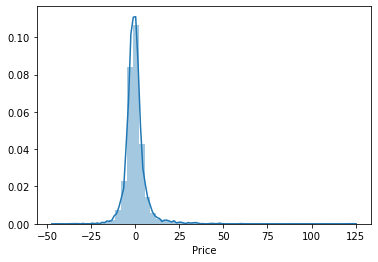

In [47]:
MAPE_train, MSSE_train, Error_train = ErrorMetric(new_model,xtrain,ytrain)
MAPE_train, MSSE_train, Error_train

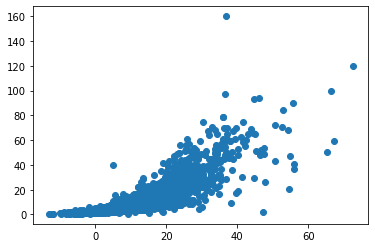

In [48]:
plt.scatter(new_model.predict(xtrain),ytrain)

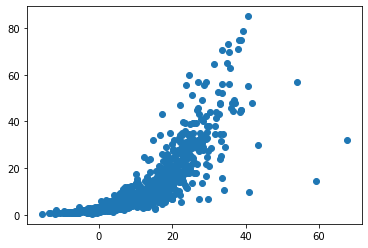

In [49]:
plt.scatter(new_model.predict(xtest),ytest)

In [53]:
y = clean_df['Price']
x = clean_df.drop(['Price','engineCC','FuelType_Diesel','mileage','Location_Kochi','Location_Delhi','Location_Pune','FuelType_LPG'],axis=1)
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.25,random_state=1234)
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape
new_model = LinearRegression()
new_model.fit(xtrain,ytrain)
print(new_model.score(xtrain,ytrain))
print(new_model.score(xtest,ytest))

0.70000423172522
0.6898005338656238


In [51]:
#–ü–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è —Å–∏–ª—å–Ω–æ –º—É–ª—å—Ç–∏–∫–æ–ª–ª–∏–Ω–µ–∞—Ä–Ω—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö –∏ –∏–∑–±—ã—Ç–æ—á–Ω—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö, –∏–º–µ—é—â–∏—Ö —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫—É—é –Ω–µ–∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å, 
#—Ç–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –æ—Å—Ç–∞–µ—Ç—Å—è –±–ª–∏–∑–∫–æ–π –∫ 70 % –Ω–∞ –æ–±—É—á–∞—é—â–µ–º –º–Ω–æ–∂–µ—Å—Ç–≤–µ –∏ 69 % –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–º –º–Ω–æ–∂–µ—Å—Ç–≤–µ.
y = clean_df['Price']
x = clean_df.drop(['Price','engineCC','FuelType_Diesel','mileage','Location_Kochi'],axis=1)
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.25,random_state=1234)
new_model = LinearRegression()
new_model.fit(xtrain,ytrain)
print(new_model.score(xtrain,ytrain))
print(new_model.score(xtest,ytest))

0.7000706125623979
0.6903132829996341


### 3. SHAP –¥–ª—è –∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏–∏ –º–æ–¥–µ–ª–∏

**Partial Dependence Plots (–≥—Ä–∞—Ñ–∏–∫–∏ —á–∞—Å—Ç–∏—á–Ω–æ–π –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –∏–ª–∏ –∂–µ PDP, PD-–≥—Ä–∞—Ñ–∏–∫–∏)** –ø–æ–∫–∞–∑—ã–≤–∞—é—Ç –Ω–µ–∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ–µ –≤–ª–∏—è–Ω–∏–µ –æ–¥–Ω–æ–≥–æ –∏–ª–∏ –¥–≤—É—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –Ω–∞ –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä—É–µ–º—ã–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç –º–æ–¥–µ–ª–∏ –º–∞—à–∏–Ω–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è. PDP –º–æ–∂–µ—Ç –ø–æ–∫–∞–∑–∞—Ç—å —Å–≤—è–∑—å –º–µ–∂–¥—É —Ü–µ–ª—å—é –∏ –≤—ã–±—Ä–∞–Ω–Ω—ã–º–∏ –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏ —Å –ø–æ–º–æ—â—å—é 1D –∏–ª–∏ 2D –≥—Ä–∞—Ñ–∏–∫–æ–≤.

–ü—É–Ω–∫—Ç–∏—Ä–Ω–∞—è –≥–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª—å–Ω–∞—è –ª–∏–Ω–∏—è –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç –æ–∂–∏–¥–∞–µ–º–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –≤—ã—Ö–æ–¥–∞ –º–æ–¥–µ–ª–∏ –ø—Ä–∏ –ø—Ä–∏–º–µ–Ω–µ–Ω–∏–∏ –∫ –Ω–∞–±–æ—Ä—É –¥–∞–Ω–Ω—ã—Ö, –≤–µ—Ä—Ç–∏–∫–∞–ª—å–Ω–∞—è –ø—É–Ω–∫—Ç–∏—Ä–Ω–∞—è –ª–∏–Ω–∏—è –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç —Å—Ä–µ–¥–Ω–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –≤–æ–∑—Ä–∞—Å—Ç–∞. –°–∏–Ω—è—è –ª–∏–Ω–∏—è –≥—Ä–∞—Ñ–∏–∫–∞ —á–∞—Å—Ç–∏—á–Ω–æ–π –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏, –∫–æ—Ç–æ—Ä–∞—è –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è–µ—Ç —Å–æ–±–æ–π —Å—Ä–µ–¥–Ω–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –≤—ã—Ö–æ–¥–∞ –º–æ–¥–µ–ª–∏ –ø—Ä–∏ —Ñ–∏–∫—Å–∞—Ü–∏–∏ –≤–æ–∑—Ä–∞—Å—Ç–∞ –Ω–∞ –∑–∞–¥–∞–Ω–Ω–æ–º –∑–Ω–∞—á–µ–Ω–∏–∏, –≤—Å–µ–≥–¥–∞ –ø—Ä–æ—Ö–æ–¥–∏—Ç —á–µ—Ä–µ–∑ —Ç–æ—á–∫—É –ø–µ—Ä–µ—Å–µ—á–µ–Ω–∏—è –¥–≤—É—Ö —Å–µ—Ä—ã—Ö –ª–∏–Ω–∏–π –æ–∂–∏–¥–∞–µ–º–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏—è. 

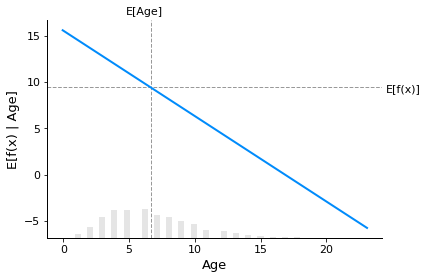

In [54]:
shap.plots.partial_dependence("Age", new_model.predict,xtrain, ice=False,
model_expected_value=True, feature_expected_value=True)

–û—Å–Ω–æ–≤–Ω–∞—è –∏–¥–µ—è, –ª–µ–∂–∞—â–∞—è –≤ –æ—Å–Ω–æ–≤–µ –æ–±—ä—è—Å–Ω–µ–Ω–∏—è –º–æ–¥–µ–ª–∏, –æ—Å–Ω–æ–≤–∞–Ω–Ω–æ–π –Ω–∞ –∑–Ω–∞—á–µ–Ω–∏–∏ Shaple, –∑–∞–∫–ª—é—á–∞–µ—Ç—Å—è –≤ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ —Ç–µ–æ—Ä–∏–∏ –∫–æ–æ–ø–µ—Ä–∞—Ç–∏–≤–Ω—ã—Ö –∏–≥—Ä –¥–ª—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –≤–æ–∑–Ω–∞–≥—Ä–∞–∂–¥–µ–Ω–∏—è –∑–∞ –≤—ã—Ö–æ–¥ –º–æ–¥–µ–ª–∏ f(ùë•) –º–µ–∂–¥—É –µ–µ –≤—Ö–æ–¥–Ω—ã–º–∏ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∞–º–∏.
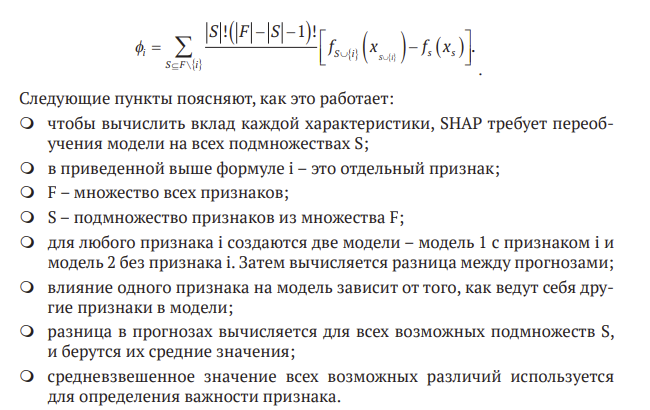

In [55]:
background = shap.maskers.Independent(xtrain, max_samples=2000)
background

In [56]:
xtrain.shape

(4514, 16)

In [57]:
explainer = shap.Explainer(new_model, background)
explainer

In [58]:
shap_values = explainer(xtrain)
shap_values

.values =
array([[ 3.21498712e+00, -4.66764217e-02,  4.88656992e+00, ...,
        -7.06748172e-03,  8.42517661e-02, -1.61673519e-02],
       [-1.39828181e+00,  2.85924841e-03, -3.71560642e+00, ...,
        -7.06748172e-03,  8.42517661e-02, -1.61673519e-02],
       [-1.39828181e+00,  1.17408602e-02, -5.53475519e+00, ...,
        -7.06748172e-03,  8.42517661e-02, -1.61673519e-02],
       ...,
       [-1.06248197e+01,  3.76680977e-02, -3.26434471e+00, ...,
        -7.06748172e-03,  8.42517661e-02, -1.61673519e-02],
       [ 1.36967955e+00,  5.77501261e-02,  9.99146802e+00, ...,
        -7.06748172e-03,  8.42517661e-02, -1.61673519e-02],
       [-4.75628027e-01,  1.89221936e-02,  8.62781154e+00, ...,
        -7.06748172e-03,  8.42517661e-02, -1.61673519e-02]])

.base_values =
array([9.61223284, 9.61223284, 9.61223284, ..., 9.61223284, 9.61223284,
       9.61223284])

.data =
array([[3.0000e+00, 2.2000e+04, 1.4780e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [8.0000e+00, 5.

In [79]:
rf_resultX =  pd.DataFrame(shap_values.values, columns = xtrain.columns)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(xtrain.columns, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance.head()

col_name  feature_importance_vals
2              powerBhp                 5.698255
0                   Age                 2.362765
12  Transmission_Manual                 1.102305
11      FuelType_Petrol                 0.649028
5   Location_Coimbatore                 0.439027

–î–ª—è –ª–∏–Ω–µ–π–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π –∑–Ω–∞—á–µ–Ω–∏–µ SHAP –¥–ª—è –∫–æ–Ω–∫—Ä–µ—Ç–Ω–æ–π —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏ ùëñ ‚Äì —ç—Ç–æ –ø—Ä–æ—Å—Ç–æ —Ä–∞–∑–Ω–æ—Å—Ç—å –º–µ–∂–¥—É –æ–∂–∏–¥–∞–µ–º—ã–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–º –º–æ–¥–µ–ª–∏ –∏ –≥—Ä–∞—Ñ–∏–∫–æ–º —á–∞—Å—Ç–∏—á–Ω–æ–π –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –ø—Ä–∏ –∑–Ω–∞—á–µ–Ω–∏–∏ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏ ùë•ùëñ —Å —É—á–µ—Ç–æ–º –∞–¥–¥–∏—Ç–∏–≤–Ω–æ–π –ø—Ä–∏—Ä–æ–¥—ã –∑–Ω–∞—á–µ–Ω–∏—è shaple

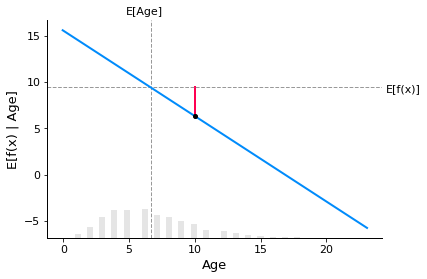

In [64]:
# –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–≥–æ –≥—Ä–∞—Ñ–∏–∫–∞ —á–∞—Å—Ç–∏—á–Ω–æ–π –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏
sample_ind = 23
fig,ax = shap.partial_dependence_plot("Age", new_model.predict, xtrain, model_expected_value=True, 
                                      feature_expected_value=True, show=False, ice=False, 
                                      shap_values=shap_values[sample_ind:sample_ind+1,:])

–¢–µ—Å–Ω–æ–µ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏–µ –º–µ–∂–¥—É –∫–ª–∞—Å—Å–∏—á–µ—Å–∫–∏–º –≥—Ä–∞—Ñ–∏–∫–æ–º —á–∞—Å—Ç–∏—á–Ω–æ–π –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏ SHAP –æ–∑–Ω–∞—á–∞–µ—Ç, —á—Ç–æ –µ—Å–ª–∏ –º—ã –Ω–∞–Ω–µ—Å–µ–º –∑–Ω–∞—á–µ–Ω–∏–µ SHAP –¥–ª—è –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω–æ–≥–æ –æ–±—ä–µ–∫—Ç–∞ –ø–æ –≤—Å–µ–º—É –Ω–∞–±–æ—Ä—É –¥–∞–Ω–Ω—ã—Ö, –º—ã —Ç–æ—á–Ω–æ –ø—Ä–æ—Å–ª–µ–¥–∏–º —Å—Ä–µ–¥–Ω–µ—Ü–µ–Ω—Ç—Ä–∏—Ä–æ–≤–∞–Ω–Ω—É—é –≤–µ—Ä—Å–∏—é –≥—Ä–∞—Ñ–∏–∫–∞ —á–∞—Å—Ç–∏—á–Ω–æ–π –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –¥–ª—è —ç—Ç–æ–≥–æ –æ–±—ä–µ–∫—Ç–∞

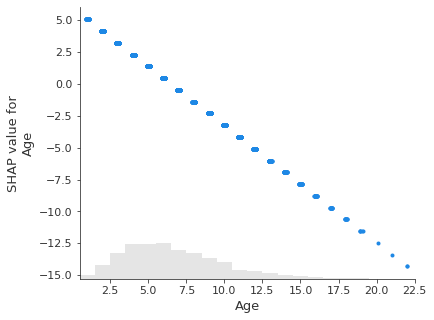

In [65]:
shap.plots.scatter(shap_values[:,"Age"])

–î–∏–∞–≥—Ä–∞–º–º–∞ –≤–æ–¥–æ–ø–∞–¥–∞, –ø–æ–∫–∞–∑—ã–≤–∞—é—â–∞—è –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã–µ –∏ –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è SHAP

In [85]:
new_model.predict(xtrain[60:61])

array([4.7269455])

In [86]:
ytrain[60:61]

2966    4.85
Name: Price, dtype: float64

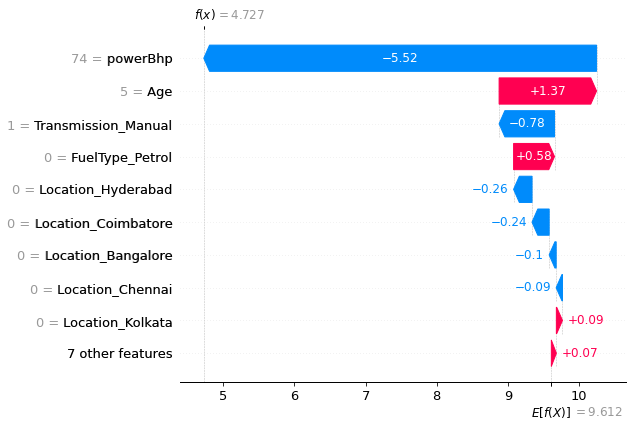

In [87]:
# –¥–∏–∞–≥—Ä–∞–º–º–∞ –≤–æ–¥–æ–ø–∞–¥–∞ –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç, –∫–∞–∫ –º—ã –ø–µ—Ä–µ—Ö–æ–¥–∏–º –æ—Ç shap_values.base_values –∫ model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[60])

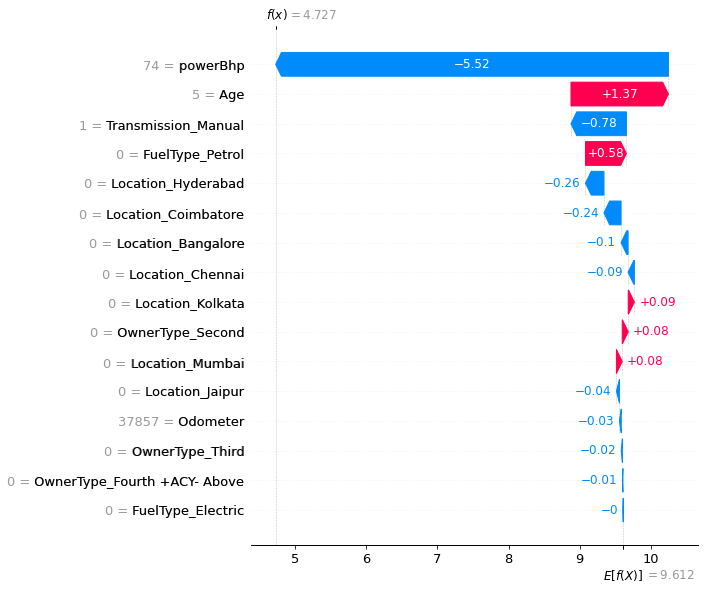

In [88]:
# –±–µ–∑ others –Ω–∞ –¥–∏–∞–≥—Ä–∞–º–º–µ
shap.plots.waterfall(shap_values[60],max_display=30)